In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
os.environ["THEANO_FLAGS"]="device=cpu,floatX=float32"

# 演習1

# データのロード

In [4]:
train = pd.read_csv("data/train_enshu1.csv")
test = pd.read_csv("data/test_enshu1.csv")

In [5]:
train.head()

,Date/Time,Base,count
0,2014-04-01,B02512,1011
1,2014-04-01,B02598,3738
2,2014-04-01,B02617,3219
3,2014-04-01,B02682,6255
4,2014-04-01,B02764,323


In [6]:
test.head()

,Date/Time,Base,count
0,2014-09-01,B02512,638
1,2014-09-01,B02598,4626
2,2014-09-01,B02617,7940
3,2014-09-01,B02682,3677
4,2014-09-01,B02764,3080


In [7]:
train = pd.pivot_table(train, index="Date/Time", columns="Base", values="count")

In [8]:
test = pd.pivot_table(test, index="Date/Time", columns="Base", values="count")

In [9]:
train.head()

Base,B02512,B02598,B02617,B02682,B02764
Date/Time,,,,,
2014-04-01,1011,3738,3219,6255,323
2014-04-02,1336,4526,3752,7515,345
2014-04-03,1482,5499,4254,9061,405
2014-04-04,1827,7151,5387,11865,484
2014-04-05,1309,5508,3691,8640,373


In [10]:
train.shape

(153, 5)

In [11]:
test.shape

(30, 5)

## データ正規化

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
diff_ma_train = train - train.rolling(7).mean()
diff_ma_test = test - test.rolling(7).mean()

In [14]:
diff_ma_train.dropna(inplace=True)
diff_ma_test.dropna(inplace=True)

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [16]:
train_f = scaler.fit_transform(diff_ma_train.values.astype(np.float32))

In [17]:
test_f = scaler.transform(diff_ma_test.values.astype(np.float32))

In [18]:
train_f.shape

(147, 5)

In [19]:
test_f.shape

(24, 5)

## データをLSTMが読み込める形式に変換

In [20]:
train_X = train_f[:-1].T.reshape((5, 146, 1))

In [21]:
train_Y = train_f[1:].T.reshape((5, 146, 1))

In [22]:
test_X = test_f[:-1].T.reshape((5, 23, 1))

In [23]:
test_Y = test_f[1:].T.reshape((5, 23, 1))

In [24]:
train_X.shape

(5, 146, 1)

## モデルの作成

In [25]:
import keras

Using Theano backend.


In [26]:
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense

In [27]:
model = Sequential()
model.add(LSTM(input_dim=1, output_dim=10, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss="mean_squared_error", optimizer="adam")

## 学習

In [28]:
model.fit(train_X, train_Y, nb_epoch=50)

Epoch 1/50
5/5 [==============================] - 0s - loss: 0.3379
Epoch 2/50
5/5 [==============================] - 0s - loss: 0.3308
Epoch 3/50
5/5 [==============================] - 0s - loss: 0.3238
Epoch 4/50
5/5 [==============================] - 0s - loss: 0.3171
Epoch 5/50
5/5 [==============================] - 0s - loss: 0.3106
Epoch 6/50
5/5 [==============================] - 0s - loss: 0.3044
Epoch 7/50
5/5 [==============================] - 0s - loss: 0.2983
Epoch 8/50
5/5 [==============================] - 0s - loss: 0.2926
Epoch 9/50
5/5 [==============================] - 0s - loss: 0.2870
Epoch 10/50
5/5 [==============================] - 0s - loss: 0.2817
Epoch 11/50
5/5 [==============================] - 0s - loss: 0.2766
Epoch 12/50
5/5 [==============================] - 0s - loss: 0.2717
Epoch 13/50
5/5 [==============================] - 0s - loss: 0.2670
Epoch 14/50
5/5 [==============================] - 0s - loss: 0.2625
Epoch 15/50
5/5 [==========================

## 評価

### 学習データに対するFitを確認

In [29]:
pred_Y_train = model.predict(train_Y)

In [30]:
pred_Y_train.shape

(5, 146, 1)

In [31]:
train_Y.shape

(5, 146, 1)

In [32]:
pred_train = pred_Y_train.reshape((5, 146))
ref_train = train_Y.reshape((5, 146))

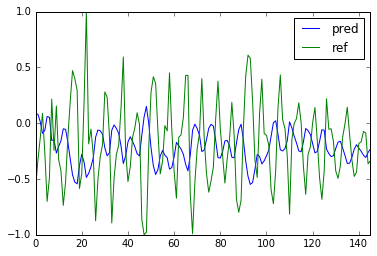

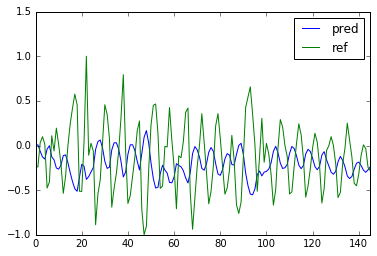

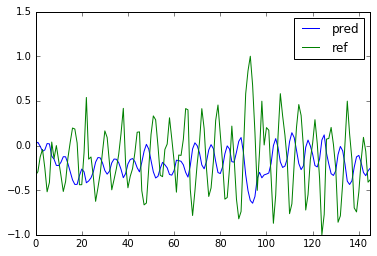

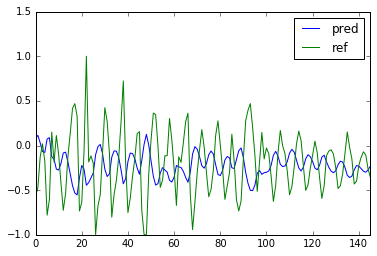

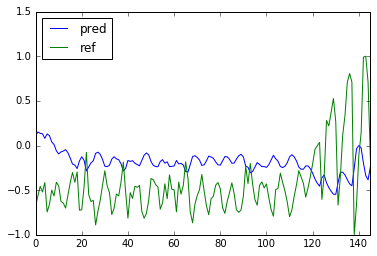

In [33]:
for i in range(5):
    pd.DataFrame(dict(pred=pred_train[i], ref=ref_train[i])).plot()

### テストデータに対するFitを確認

In [34]:
pred_Y = model.predict(test_X)

In [35]:
pred_Y.shape

(5, 23, 1)

In [36]:
test_Y.shape

(5, 23, 1)

In [37]:
pred = pred_Y.reshape((5, 23))
ref = test_Y.reshape((5, 23))

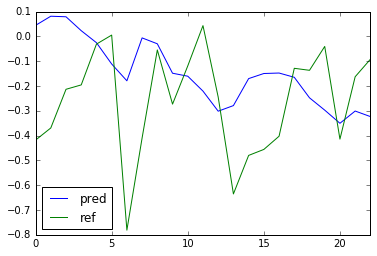

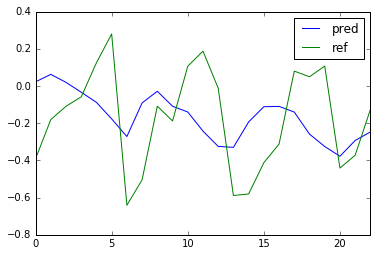

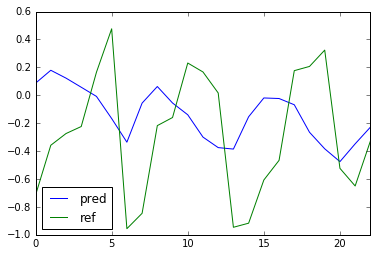

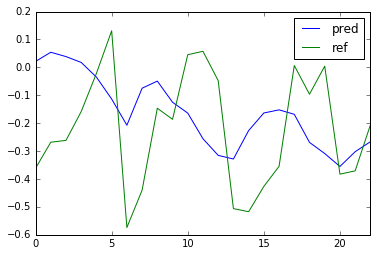

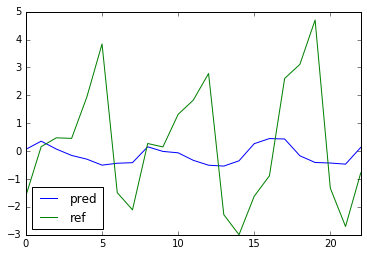

In [38]:
for i in range(5):
    pd.DataFrame(dict(pred=pred[i], ref=ref[i])).plot()

## たくさん反復した時の性能を見てみましょう

10000反復したモデルを付属していますので、その時の性能を確認しましょう。

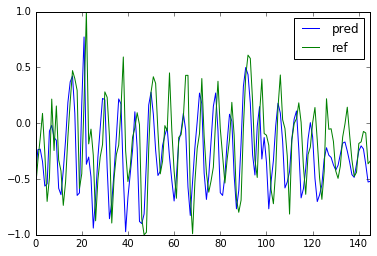

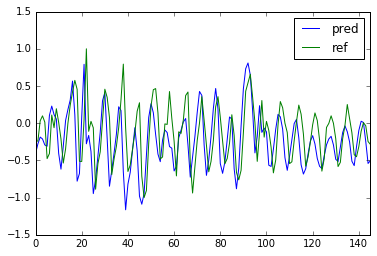

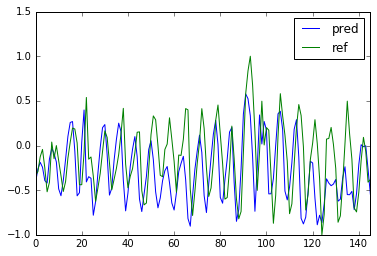

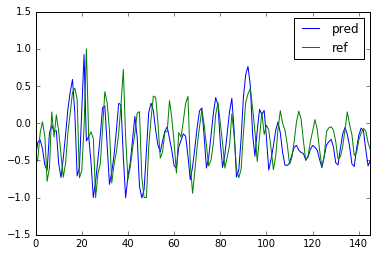

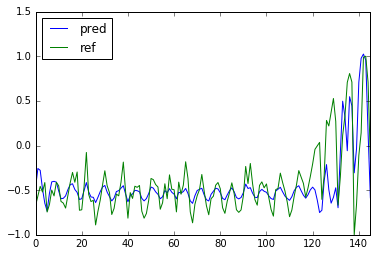

In [39]:
hiden = keras.models.load_model("data/hiden_no_tare_enshu1.h5")
pred_Y_hiden_train = hiden.predict(train_Y)
pred_hiden_train = pred_Y_hiden_train.reshape((5, 146))
for i in range(5):
    pd.DataFrame(dict(pred=pred_hiden_train[i], ref=ref_train[i])).plot()

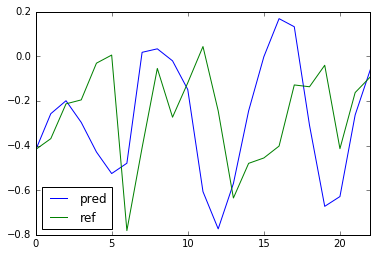

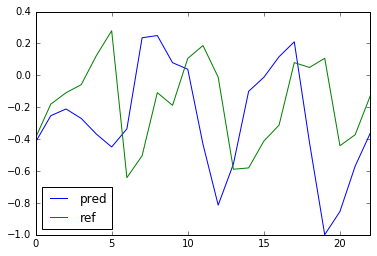

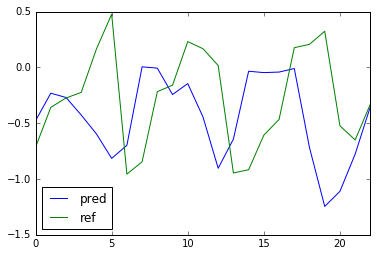

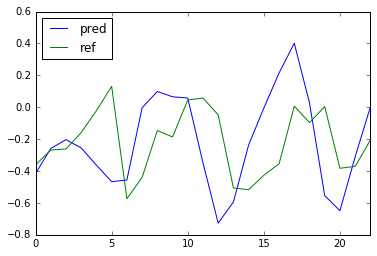

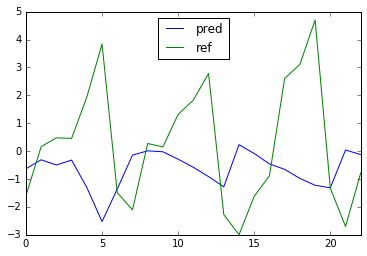

In [40]:
pred_Y_hiden = hiden.predict(test_Y)
pred_hiden = pred_Y_hiden.reshape((5, 23))
for i in range(5):
    pd.DataFrame(dict(pred=pred_hiden[i], ref=ref[i])).plot()

## モデル出力から予測値に変換

In [41]:
test.rolling(7).mean().iloc[6:].shape, scaler.inverse_transform(pred_hiden.T).shape

((24, 5), (23, 5))

In [42]:
predicted_final = test.rolling(7).mean().iloc[7:] + scaler.inverse_transform(pred_hiden.T)

In [43]:
predicted_final.shape, test.values.shape

((23, 5), (30, 5))

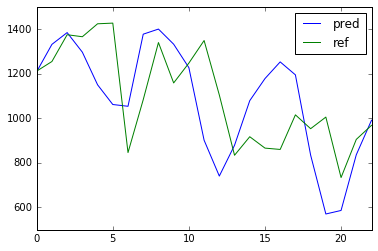

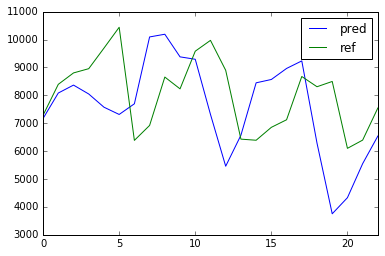

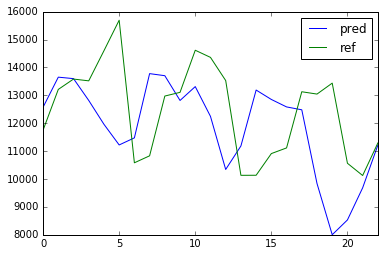

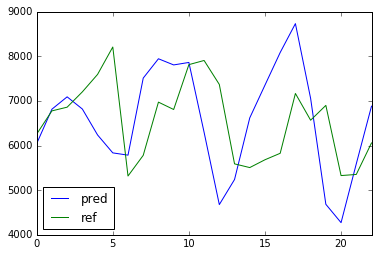

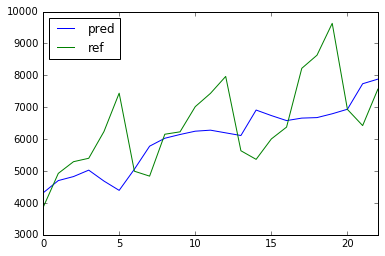

In [44]:
for i in range(5):
    pd.DataFrame(dict(pred=predicted_final.values[:, i], ref=test.values[7:, i])).plot()